### Model

In [ ]:
!pip install -U transformers --q
!pip install sentencepiece --q
!pip install tokenizers  --q

     |████████████████████████████████| 4.7 MB 31.9 MB/s 
     |████████████████████████████████| 120 kB 72.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.4 MB/s 
     |████████████████████████████████| 1.3 MB 12.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,AutoModel,RobertaModel
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

def prepare_reduced_data(data):
    df=data
    df=df.set_index(pd.Series(list(range(30003))))
    df['Label'] = df['Label'].map({'Fake':0,'Real':1})
    return df

def defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME):
    tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    return tokenizer

class GPReviewDataset(Dataset):
    
    def __init__(self, doc, targets, tokenizer, max_len):
        self.doc = doc
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.doc)
  
    def __getitem__(self, item):
        doc = str(self.doc[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
                    doc,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                    )

        return {
            'doc_text': doc,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        doc=df.Title.to_numpy(),
        targets=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
        )

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
    ):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["doc_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)  
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


if __name__=="__main__":
    
    full_data=pd.read_csv('/content/drive/MyDrive/urdu/urdu.csv')
    df=prepare_reduced_data(full_data)

    class_names=['FAKE', 'REAL']
    PRE_TRAINED_MODEL_NAME = 'urduhack/roberta-urdu-small'
    tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

    sample_txt='Personal Health Record (Extract)\nCreated on October 24, 2019\nPatient\nSteven Fuerst\nBirthdate\nDecember 10, 1979\nRace\nInformation not\navailable'

    tokens = tokenizer.tokenize(sample_txt)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    encoding = tokenizer.encode_plus(
                      sample_txt,
                      max_length=128,
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      return_token_type_ids=False,
                      pad_to_max_length=True,
                      return_attention_mask=True,
                      return_tensors='pt',  # Return PyTorch tensors
                    )

    
    
    MAX_LEN = 512
    BATCH_SIZE = 4

    df_train, df_test = train_test_split(df, test_size=0.4, random_state=RANDOM_SEED)
    df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    data = next(iter(train_data_loader))

    bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    last_hidden_state, pooled_output = bert_model(
                    input_ids=encoding['input_ids'], 
                    attention_mask=encoding['attention_mask'])

    model = SentimentClassifier(len(class_names))
    model = model.to(device)

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)


    EPOCHS = 4

    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss().to(device)


    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), '/content/drive/MyDrive/urdu/roberta_model_state.bin')
            best_accuracy = val_acc
        
    test_acc, _ = eval_model(
          model,
          test_data_loader,
          loss_fn,
          device,
          len(df_test)
        )
    print('\nTest Accuracy:\n')
    print(test_acc.item())

    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
    )

    print(classification_report(y_test, y_pred, target_names=class_names))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoa

Some weights of the model checkpoint at urduhack/roberta-urdu-small were not used when initializing BertModel: ['roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.8.intermediate.dense.weight', 'roberta.encoder.layer.0.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.1.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.dense.weight', 'roberta.encoder.layer.6.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.1.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.6.attention.self.value.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.9.output.dense.weight', 'robert

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Train loss 0.5569947467716707 accuracy 0.7476251319371147
Val   loss 0.47653232773717524 accuracy 0.7858690218296951

Epoch 2/4
----------
Train loss 0.4996389059787105 accuracy 0.7930670518304539
Val   loss 0.48016850740805783 accuracy 0.7937010498250292

Epoch 3/4
----------
Train loss 0.4706751781901052 accuracy 0.8069551691572691
Val   loss 0.5026577065513748 accuracy 0.7950341609731711

Epoch 4/4
----------
Train loss 0.44676506789356685 accuracy 0.8147880673295929
Val   loss 0.5337591741899826 accuracy 0.7955340776537244


Test Accuracy:

0.78920179970005
              precision    recall  f1-score   support

        FAKE       0.71      0.96      0.82      2949
        REAL       0.94      0.62      0.75      3052

    accuracy                           0.79      6001
   macro avg       0.83      0.79      0.78      6001
weighted avg       0.83      0.79      0.78      6001



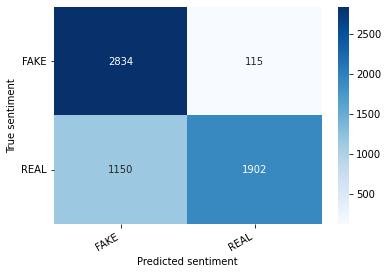

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### predictions

In [1]:
!pip install -U transformers --q
!pip install tokenizers  --q

     |████████████████████████████████| 4.7 MB 31.6 MB/s 
     |████████████████████████████████| 6.6 MB 60.3 MB/s 
     |████████████████████████████████| 120 kB 51.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [9]:
import torch
from torch import nn
from transformers import AutoTokenizer, RobertaModel

import string
import re
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

class_names=['FAKE', 'REAL']
PRE_TRAINED_MODEL_NAME = 'urduhack/roberta-urdu-small'

roberta_model = SentimentClassifier(len(class_names))

roberta_model.load_state_dict(torch.load('/content/drive/MyDrive/urdu/roberta_model_state.bin', map_location='cpu'))
roberta_model = roberta_model.to(device)

roberta_tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
review_text = 'حالیہ ہفتوں میں، کئی ذرائع ابلاغ نے چین کی جانب سے اسکاربورو کے ساحل میں فلپائنی ماہی گیروں کو ہراساں کیے جانے کے بارے میں رپورٹ کیا۔'

encoded_review = roberta_tokenizer.encode_plus(
  review_text,
  max_length = 512,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = roberta_model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Label  : {class_names[prediction]}')

Some weights of the model checkpoint at urduhack/roberta-urdu-small were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style

Review text: حالیہ ہفتوں میں، کئی ذرائع ابلاغ نے چین کی جانب سے اسکاربورو کے ساحل میں فلپائنی ماہی گیروں کو ہراساں کیے جانے کے بارے میں رپورٹ کیا۔
Label  : FAKE


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Review text: حالیہ ہفتوں میں، کئی ذرائع ابلاغ نے چین کی جانب سے اسکاربورو کے ساحل میں فلپائنی ماہی گیروں کو ہراساں کیے جانے کے بارے میں رپورٹ کیا۔
Label  : FAKE
